# Árvores de decisão

## Intuição

In [1]:
from sklearn.datasets import load_iris

iris = load_iris()
X, y = iris.data[:,2:], iris.target

import matplotlib.pyplot as plt
plt.xlabel(f"X[0]: {iris.feature_names[0]}")
plt.ylabel(f"X[1]: {iris.feature_names[1]}")
for k in set(y):
    plt.plot(X[:,0][y==k], X[:,1][y==k], "o", label=f"{iris.target_names[k]} [{k}]", alpha=0.5)
plt.plot([2.5, 2.5], [0  , 2.5])
plt.plot([2.5 , 7], [1.75, 1.75])
plt.legend()
plt.show()

In [2]:
from sklearn.metrics import accuracy_score
import numpy as np
from scipy import stats

def maisFrequente(y):
    return stats.mode(y)[0]

class Arvore():
    def fit(self, X, y):
        self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        y[:] = self.resposta
        return y

modelo = Arvore()
modelo.fit(X,y)
ypred = modelo.predict(X)
accuracy_score(y, ypred)#, (ypred == y)

0.3333333333333333

In [3]:
from sklearn.metrics import accuracy_score
import numpy as np
from scipy import stats

def maisFrequente(y):
    return stats.mode(y)[0]

class Arvore():
    def __init__(self):
        self.caracteristica, self.valor = 0, 2.5
    def fit(self, X, y):
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores) == 0 or sum(~maiores) == 0:
            self.resposta = maisFrequente(y)
        else:
            self.maiores = Arvore()
            self.maiores.fit(X[maiores,:], y[maiores])
            self.menores = Arvore()
            self.menores.fit(X[~maiores,:], y[~maiores])
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

modelo = Arvore()
modelo.fit(X,y)
ypred = modelo.predict(X)
accuracy_score(y, ypred)#, (ypred == y)

0.6666666666666666

In [4]:
from sklearn.metrics import accuracy_score
import numpy as np
from scipy import stats

def maisFrequente(y):
    return stats.mode(y)[0]

class Arvore():
    def __init__(self):
        self.caracteristica = 0
    def fit(self, X, y):
        self.valor = np.mean(X[:,self.caracteristica])
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores) == 0 or sum(~maiores) == 0:
            self.resposta = maisFrequente(y)
        else:
            self.maiores = Arvore()
            self.maiores.fit(X[maiores,:], y[maiores])
            self.menores = Arvore()
            self.menores.fit(X[~maiores,:], y[~maiores])
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

modelo = Arvore()
modelo.fit(X,y)
ypred = modelo.predict(X)
accuracy_score(y, ypred)#, (ypred == y)

0.9533333333333334

## Regiões de decisão

0.9533333333333334


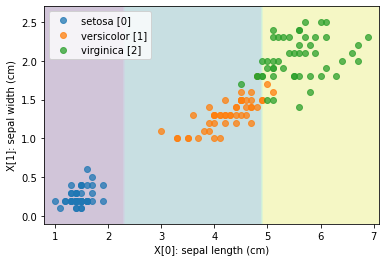

In [5]:
import matplotlib.pyplot as plt

def plotDecisao(modelo, X, y):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], "o", label=f"{iris.target_names[k]} [{k}]", alpha=0.75)
    plt.xlabel(f"X[0]: {iris.feature_names[0]}")
    plt.ylabel(f"X[1]: {iris.feature_names[1]}")
    plt.legend()
    print(accuracy_score(y, modelo.predict(X)))
    plt.show()

plotDecisao(modelo, X, y)

0.9933333333333333


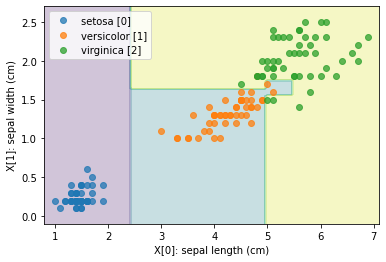

In [6]:
from sklearn.tree import DecisionTreeClassifier
plotDecisao(DecisionTreeClassifier(), X, y)

0.96


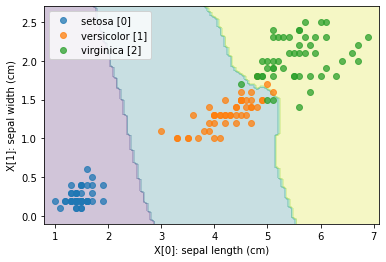

In [7]:
from sklearn.neighbors import KNeighborsClassifier
plotDecisao(KNeighborsClassifier(), X, y)

0.9666666666666667


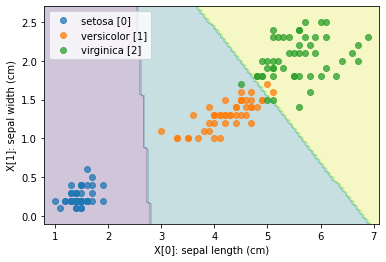

In [8]:
from sklearn.linear_model import LogisticRegression
plotDecisao(LogisticRegression(), X, y)

## Escolhendo a característica de cada nó

In [9]:
def impureza(y):
    labels = list(set(y))
    labels.sort()
    probabilidade = np.zeros((len(labels),))
    for k in range(len(labels)):
        probabilidade[k] = sum(y==k)/len(y)
    result = 1 - sum(probabilidade**2)
    return result

ytmp = y[:]
valor = impureza(ytmp)
valor

0.6666666666666667

In [10]:
def impurezaLimiar(x, y, limiar):
    maiores = x>limiar
    impurezamaiores = impureza(y[maiores])
    propmaiores = (sum(maiores)/len(y))
    impurezamenores = impureza(y[~maiores])
    propmenores = (sum(~maiores)/len(y))
    impurezatotal =  propmaiores*impurezamaiores + propmenores*impurezamenores
    return impurezatotal, impurezamaiores, impurezamenores
impurezaLimiar(X[:,0], y, 2)

(0.5, 0.75, 0.0)

0.9533333333333334


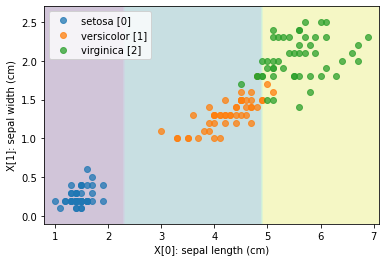

In [11]:
plotDecisao(Arvore(), X, y)

In [12]:
def melhorLimiar(x, y):
    result = None
    menorimpureza = float('inf')
    xmax = np.max(x)
    xmin = np.min(x)
    while True:
        limiar = (xmin+xmax)/2
        impurezatotal, impurezamaiores, impurezamenores =  impurezaLimiar(x, y, limiar)
        if impurezatotal < menorimpureza:
            menorimpureza = impurezatotal
            result = limiar
            if impurezamenores == 0 or impurezamaiores == 0:
                break
            if impurezamaiores < impurezamenores:
                xmin = limiar
            else:
                xmax = limiar
        else:
            break
    return result, menorimpureza
melhorLimiar(X[:,0], y)

(2.475, 0.5)

In [13]:
def caracteristicaComMenorImpureza(X, y):
    impurezas = []
    limiares = []
    for caracteristica in range(X.shape[1]):
        limiar, impurezalimiar = melhorLimiar(X[:,caracteristica], y)
        impurezas.append(impurezalimiar)
        limiares.append(limiar)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, limiares[caracteristica], impurezas[caracteristica]
print(caracteristicaComMenorImpureza(X[:,::],y))

(0, 2.475, 0.5)


In [14]:
from sklearn.metrics import accuracy_score
import numpy as np
from scipy import stats

def maisFrequente(y):
    return stats.mode(y)[0]

class Arvore():
    def __init__(self):
        self.caracteristica, self.valor = 0, 2.5
    def fit(self, X, y):
        self.caracteristica, self.valor, self.impureza = caracteristicaComMenorImpureza(X, y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores) == 0 or sum(~maiores) == 0:
            self.resposta = maisFrequente(y)
        else:
            self.maiores = Arvore()
            self.maiores.fit(X[maiores,:], y[maiores])
            self.menores = Arvore()
            self.menores.fit(X[~maiores,:], y[~maiores])
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

modelo = Arvore()
modelo.fit(X,y)
ypred = modelo.predict(X)
accuracy_score(y, ypred)#, (ypred == y)

0.9733333333333334

0.9733333333333334


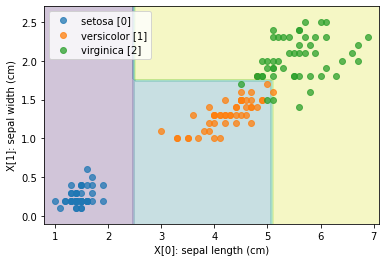

In [15]:
plotDecisao(modelo, X, y)

In [16]:
from sklearn.model_selection import cross_validate
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from scipy import stats

def maisFrequente(y):
    return stats.mode(y)[0]

class Arvore(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.caracteristica, self.valor = 0, 2.5
    def fit(self, X, y):
        self.caracteristica, self.valor, self.impureza = caracteristicaComMenorImpureza(X, y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores) == 0 or sum(~maiores) == 0:
            self.resposta = maisFrequente(y)
        else:
            self.maiores = Arvore()
            self.maiores.fit(X[maiores,:], y[maiores])
            self.menores = Arvore()
            self.menores.fit(X[~maiores,:], y[~maiores])
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

scores = cross_validate(Arvore(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.96666667, 0.96666667, 0.83333333, 0.9       , 1.        ]),
 0.9333333333333332)